In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
import json
import re
from gensim import models, corpora
from nltk.tokenize import sent_tokenize, word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels
from math import ceil, floor

In [74]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('x\\b')
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     text = BeautifulSoup(text)
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

def print_plot(index,data):
    example = data[data.index == index][['id', 'category','description']].values[0]
    if len(example) > 0:
        print('Unique ID :',example[0])
        print('------------------------')
        print('Class:'+ example[1])
        print('------------------------')
        print('Description:', example[2])
        print('------------------------')
        print('Description:', clean_text(example[2]))


In [75]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=10):
            dropCategory.append(key)
    return dropCategory

In [76]:


data = pd.read_csv('../example/real.csv')
data = pd.DataFrame({'id':data['JobNumber'],'Name':data['JobName'],'RWCategory':data['RW Category'],'category':data['RW Job Type'],'description':data['Details']})
data = data[data['RWCategory']=='Freeformat Text']
data = data.drop(columns=['RWCategory'])
data = data[pd.notnull(data['description'])]
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 0 to 950
Data columns (total 4 columns):
id             562 non-null object
Name           562 non-null object
category       562 non-null object
description    562 non-null object
dtypes: object(4)
memory usage: 22.0+ KB


In [77]:
data.category.value_counts()

Leaflet                      75
DPLM                         71
POS                          70
Mail Pack                    64
Promo                        62
Posters                      50
Booklet                      43
Letter                       34
Suppressions                 29
Envelope                     19
Postage                      13
Folder                        9
Stickers                      4
Deliveries                    3
Business Cards                2
Dividers & Content Sheets     2
Data charges                  2
Die Forms                     2
Cheque Pouch                  1
Christmas Card                1
Pad                           1
Pollywrap                     1
Passbook                      1
Artwork                       1
NCR Pad                       1
Plastic Cards                 1
Name: category, dtype: int64

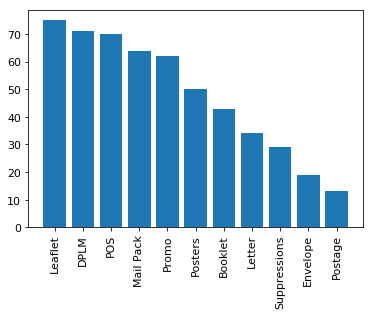

In [78]:
dropClass = classNumberThreshold(data.category.value_counts())
for ele in dropClass:
    data = data[data['category']!=ele]

value_count = data.category.value_counts()
fig, axs = plt.subplots()
axs.bar(value_count.index, value_count.values)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
fig.savefig("C/dataDistribution.png")

In [79]:
print_plot(10,data)
data.info()

Unique ID : J/2690
------------------------
Class:Posters
------------------------
Description: A1 - 1pp||Printed full colour||170gsm Silk||Trim to size||Supplied in bulk, flat on pallets and separated by kind||||11-0517ABCD	Brand ISA Campaign - Lead Brand Savings 4xA1 poster sets x 180 sets of 4||11-0518	Brand ISA Campaign - Lead Brand Savings single A1 posters x 260||11-0519ABCD	Brand ISA Campaign - Support Brand ISA 4xA1 poster sets	x 150 sets of 4||11-0520	Brand ISA Campaign - Support Brand ISA single A1 posters x 180||11-0522	Brand ISA Campaign - LISA Internal Single A1 poster x 280||11-0523	Brand ISA Campaign - Internal Colleague Poster 1 x 190||11-0524	Brand ISA Campaign - Internal Colleague Poster 2 x 190
------------------------
Description: pp printed full colour gsm silk trim size supplied bulk flat pallets separated kind abcdbrand isa campaign lead brand savings xa poster sets sets brand isa campaign lead brand savings single posters abcdbrand isa campaign support brand isa

In [80]:
data['description'] = data.description.apply(clean_text)
input_Text = data.description[0]
print(input_Text)

print('---------------- \n')

print('Sentence tokenizer:')

print(sent_tokenize(input_Text))

print('\n Word tokenizer:')

print(word_tokenize(input_Text))

print('\n Word punct tokenizer: ')

print(WordPunctTokenizer().tokenize(input_Text))

new_input = WordPunctTokenizer().tokenize(input_Text)

title header panel finished size mm artwork print ready files supplied proofs pdf proof printing colour process face materials mm foam pvc finishing cut shape apply velcro hook loop around edges bubble wrap delivery laura shackleton marketing skipton ho tuesday st jan
---------------- 

Sentence tokenizer:
['title header panel finished size mm artwork print ready files supplied proofs pdf proof printing colour process face materials mm foam pvc finishing cut shape apply velcro hook loop around edges bubble wrap delivery laura shackleton marketing skipton ho tuesday st jan']

 Word tokenizer:
['title', 'header', 'panel', 'finished', 'size', 'mm', 'artwork', 'print', 'ready', 'files', 'supplied', 'proofs', 'pdf', 'proof', 'printing', 'colour', 'process', 'face', 'materials', 'mm', 'foam', 'pvc', 'finishing', 'cut', 'shape', 'apply', 'velcro', 'hook', 'loop', 'around', 'edges', 'bubble', 'wrap', 'delivery', 'laura', 'shackleton', 'marketing', 'skipton', 'ho', 'tuesday', 'st', 'jan']

 Wor

In [81]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

# Create various stemmer objects

porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer('english')

In [82]:
stemName = ['PORTER', 'LANCASTER', 'SNOWBALL']
formatted_text = '{:>16}'*(len(stemName)+1)
print('\n',formatted_text.format('Input Word',*stemName),'\n','='*68)

for word in new_input:
    output = [word, porter.stem(word), lancaster.stem(word), snowball.stem(word)]
    print(formatted_text.format(*output))


       Input Word          PORTER       LANCASTER        SNOWBALL 
           title            titl            titl            titl
          header          header            head          header
           panel           panel           panel           panel
        finished          finish             fin          finish
            size            size             siz            size
              mm              mm              mm              mm
         artwork         artwork         artwork         artwork
           print           print           print           print
           ready           readi           ready           readi
           files            file             fil            file
        supplied          suppli          supply          suppli
          proofs           proof           proof           proof
             pdf             pdf             pdf             pdf
           proof           proof           proof           proof
        printing      

In [83]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizerName = ['Noun Lemmatizer', 'Verb :emmatizer']
formattedText = '{:>24}'*(len(lemmatizerName)+1)
# print(formattedText)
print('\n',formattedText.format('Input Word', *lemmatizerName),'\n','='*75)

for word in new_input:
    output = [word, lemmatizer.lemmatize(word,pos = 'n'), lemmatizer.lemmatize(word,pos = 'v')]
    print(formattedText.format(*output))


               Input Word         Noun Lemmatizer         Verb :emmatizer 
                   title                   title                   title
                  header                  header                  header
                   panel                   panel                   panel
                finished                finished                  finish
                    size                    size                    size
                      mm                      mm                      mm
                 artwork                 artwork                 artwork
                   print                   print                   print
                   ready                   ready                   ready
                   files                    file                    file
                supplied                supplied                  supply
                  proofs                   proof                   proof
                     pdf                     pdf

In [84]:
def lemmatizer_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word,pos = 'v') for word in text.split())
    return text

data.description = data.description.apply(lemmatizer_text)

In [87]:
from nltk.tokenize import RegexpTokenizer
def createToken(inputText):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(inputText)
    
    return tokens
newToken = [createToken(x) for x in data.description]

In [88]:
dictTokens = corpora.Dictionary(newToken)

docTermMatrix = [dictTokens.doc2bow(tk) for tk in newToken]

numTopic = len(np.unique(data.category))

In [90]:
ladaModel = models.ldamodel.LdaModel(docTermMatrix, num_topics=numTopic, id2word=dictTokens, passes= 25)
numTop5 = 10

print('\n Top5'+ str(numTop5) + 'contributing words to each topic: ')

for item in ladaModel.print_topics(num_topics = numTopic, num_words = numTop5):
    print('\nTopic', item[0])
    
#     Contributing words along with their relative contribution
    list_of_strings = item[1].split(' + ')
    for text in list_of_strings:
        weight = text.split('*')[0]
        word = text.split('*')[1]
        print(word, '==>', str(round(float(weight)*100,2))+'%')


 Top510contributing words to each topic: 

Topic 0
"colour" ==> 2.9%
"mm" ==> 2.8%
"print" ==> 2.7%
"full" ==> 2.5%
"personalise" ==> 2.4%
"data" ==> 2.2%
"mail" ==> 2.1%
"insert" ==> 1.7%
"bag" ==> 1.7%
"fold" ==> 1.6%

Topic 1
"letter" ==> 5.5%
"booklet" ==> 5.3%
"release" ==> 5.1%
"gsm" ==> 4.9%
"supply" ==> 4.2%
"dsa" ==> 3.7%
"c" ==> 3.5%
"outer" ==> 3.1%
"provider" ==> 2.9%
"pp" ==> 2.8%

Topic 2
"print" ==> 4.6%
"finish" ==> 3.9%
"mm" ==> 3.8%
"supply" ==> 3.7%
"colour" ==> 3.4%
"proof" ==> 2.9%
"size" ==> 2.6%
"cut" ==> 2.5%
"flat" ==> 2.4%
"shape" ==> 2.3%

Topic 3
"letter" ==> 5.2%
"print" ==> 3.6%
"insert" ==> 3.3%
"supply" ==> 3.2%
"require" ==> 2.9%
"release" ==> 2.8%
"personalise" ==> 2.7%
"sample" ==> 2.3%
"fold" ==> 2.3%
"account" ==> 2.1%

Topic 4
"mm" ==> 8.4%
"colour" ==> 3.9%
"envelope" ==> 3.7%
"window" ==> 3.2%
"face" ==> 2.5%
"size" ==> 2.1%
"black" ==> 2.1%
"flap" ==> 2.0%
"gsm" ==> 2.0%
"print" ==> 1.7%

Topic 5
"side" ==> 7.1%
"one" ==> 5.3%
"colour" ==> 5.1%

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 950
Data columns (total 4 columns):
id             530 non-null object
Name           530 non-null object
category       530 non-null object
description    530 non-null object
dtypes: object(4)
memory usage: 40.7+ KB


In [92]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7,ngram_range=(1,3))
X = tfidfconverter.fit_transform(data.description)
total_feature = X.shape[1]

le = LabelEncoder()
le.fit(data.category)
target = le.classes_
labels = le.transform(data.category)
y = pd.DataFrame({'id':data.id,'category':labels,'categoryName':target[labels],'originText':data.description.apply(clean_text)})

In [93]:
X_train, X_test, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state = 27)
y_train = yTrain.category
y_test = yTest.category

In [94]:
from keras.preprocessing.text import Tokenizer
data = yTrain.originText
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
trainlengths = [len(ele) for ele in sequences]
max(trainlengths), np.mean(trainlengths)

(86, 20.41509433962264)

In [95]:
scores = []
nums = []
print("Total features: "+ str(total_feature))
for num in range(50,total_feature,50):
    selectBest = SelectKBest(chi2, k=num).fit(X_train, y_train)
    Xtrainbest = selectBest.transform(X_train)
    Xtestbest = selectBest.transform(X_test)
    model = LinearSVC(random_state=42,class_weight="balanced")
    model.fit(Xtrainbest,y_train)
    score = model.score(Xtestbest,y_test)
    scores.append(score)
    nums.append(num)

index = np.argmax(scores)
print("Best size: "+ str(nums[index]) + " Best accuracy: "+ str(max(scores))) 

Total features: 1167
Best size: 700 Best accuracy: 0.9433962264150944


In [96]:
selectBest = SelectKBest(chi2, k=nums[index]).fit(X_train, y_train)
Xtrainbest = selectBest.transform(X_train)
Xtestbest = selectBest.transform(X_test)

In [97]:

%time
# 5.01
model.fit(Xtrainbest,y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [98]:
coef = model.coef_
y_confidence = model.decision_function(Xtestbest)


In [99]:
%time
y_pred = model.predict(Xtestbest)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [100]:
print(classification_report(y_test, y_pred,target_names=target))


              precision    recall  f1-score   support

     Booklet       1.00      1.00      1.00         6
        DPLM       1.00      1.00      1.00        11
    Envelope       1.00      1.00      1.00         4
     Leaflet       0.83      1.00      0.91        10
      Letter       1.00      1.00      1.00         8
   Mail Pack       1.00      0.93      0.96        14
         POS       0.89      0.89      0.89        18
     Postage       1.00      1.00      1.00         1
     Posters       1.00      0.94      0.97        16
       Promo       0.85      0.85      0.85        13
Suppressions       1.00      1.00      1.00         5

   micro avg       0.94      0.94      0.94       106
   macro avg       0.96      0.96      0.96       106
weighted avg       0.95      0.94      0.94       106

